In [1]:
print ('Hi, I am Abdullah')

Hi, I am Abdullah


In [2]:
print ('Working for Basic Walk-Through: k-nearest Neighbors')

Working for Basic Walk-Through: k-nearest Neighbors


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve


In [5]:
sns.set_style('whitegrid')

In [6]:
DATA_PATH = Path('..', 'data')

In [7]:
import os
work_dirctory = os.getcwd()
print(work_dirctory)
house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

/notebook/tutorials/Pint
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


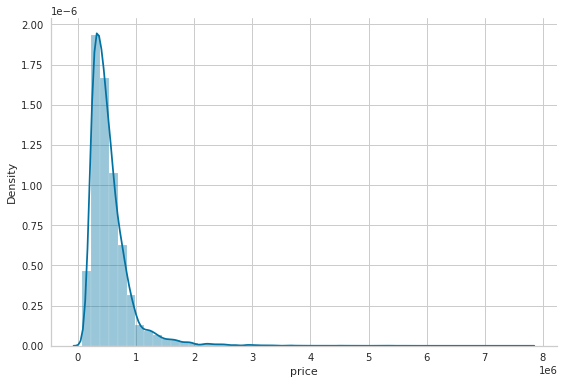

In [8]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

In [9]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

In [10]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

grade            0.348848
sqft_living      0.348094
sqft_living15    0.269913
sqft_above       0.261248
bathrooms        0.210496
sqft_lot15       0.085905
bedrooms         0.080023
floors           0.073721
yr_built         0.073293
sqft_basement    0.071127
sqft_lot         0.063458
view             0.057129
condition        0.013777
yr_renovated     0.012294
waterfront       0.012108
dtype: float64

In [11]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

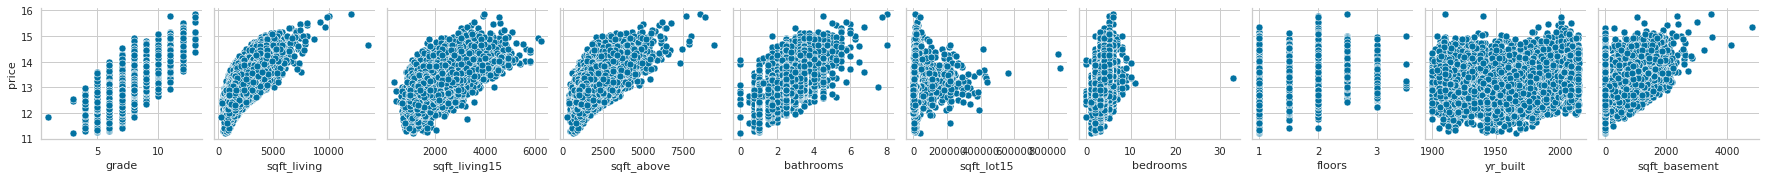

In [12]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grade          21613 non-null  int64  
 1   sqft_living    21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   yr_built       21613 non-null  int64  
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


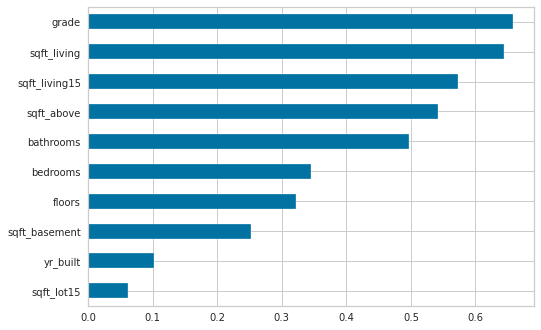

In [14]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

In [15]:
X_scaled = scale(X)

In [16]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [17]:
y_pred = model.predict(X_scaled)

In [18]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

In [19]:
error = (y - y_pred).rename('Prediction Errors')

In [20]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

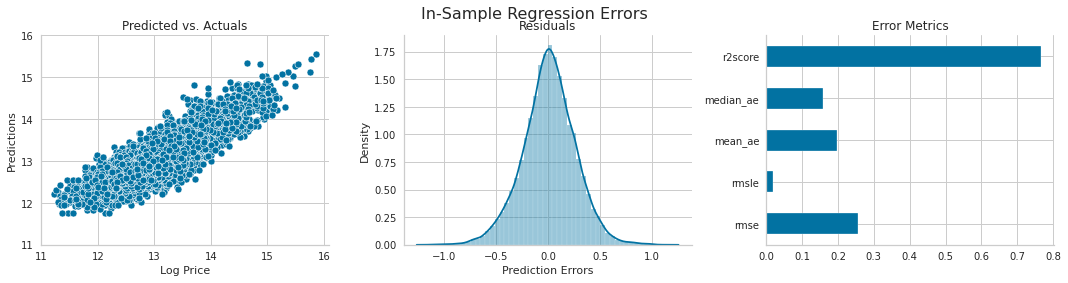

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

In [22]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [23]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])                    
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)

In [24]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

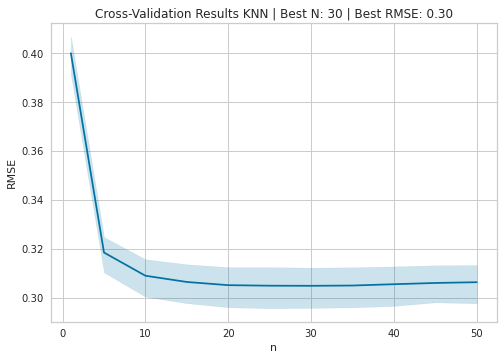

In [25]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

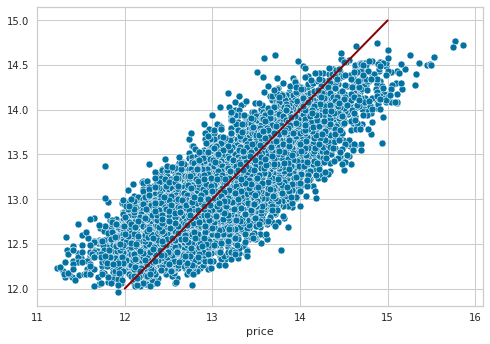

In [26]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');

In [27]:
error = (y - y_pred).rename('Prediction Errors')

In [28]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

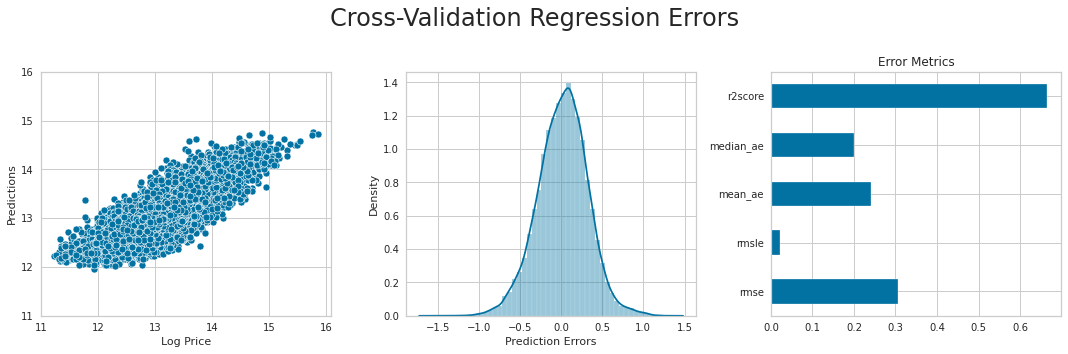

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

In [35]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [36]:
cv_results = estimator.cv_results_

In [37]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

In [38]:
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

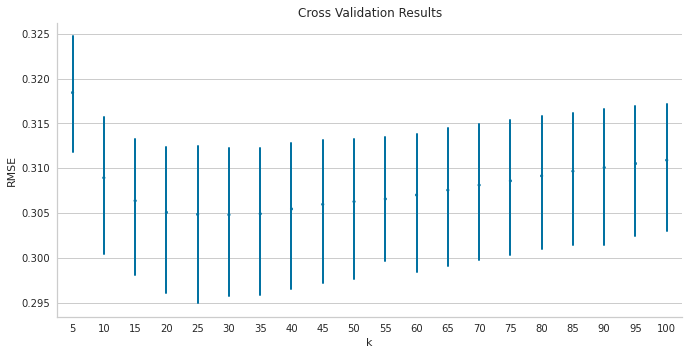

In [39]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

In [43]:
y_binary = (y>y.median()).astype(int)

In [44]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [45]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [46]:
best_k = estimator.best_params_['knn__n_neighbors']

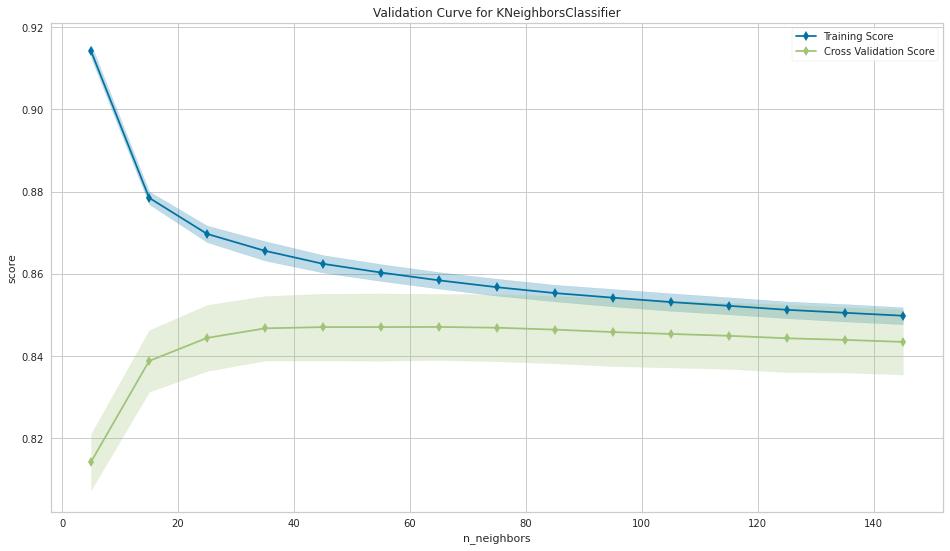

<Figure size 576x396 with 0 Axes>

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

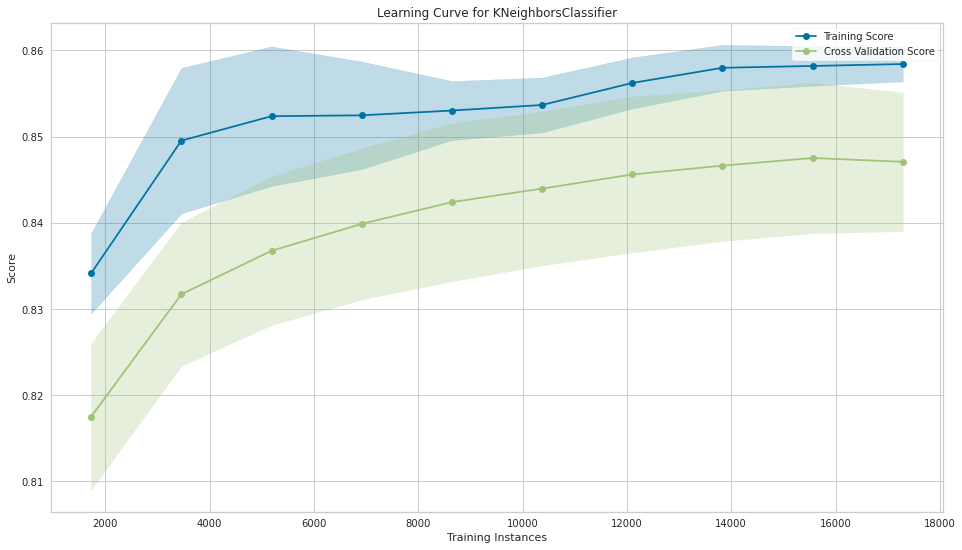

<Figure size 576x396 with 0 Axes>

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

In [52]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

In [53]:
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict_proba')[:, 1]

In [54]:
pred_scores = dict(y_true=y_binary,y_score=y_score)

In [55]:
roc_auc_score(**pred_scores)

0.8460220757597617

In [56]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [57]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

In [58]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

In [59]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


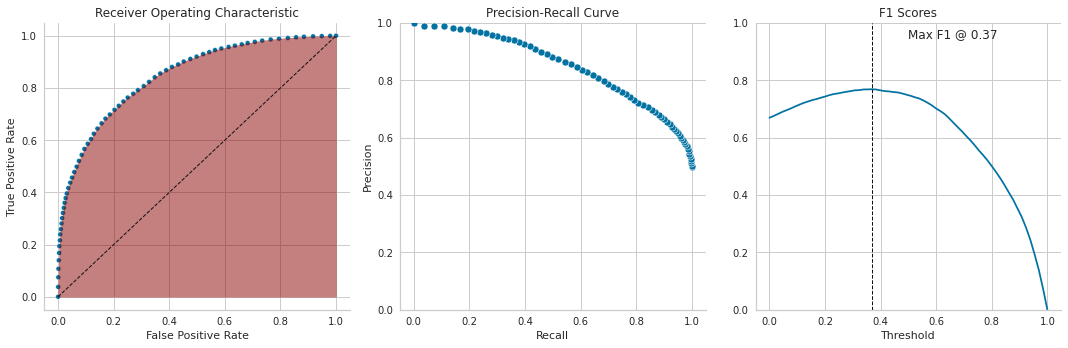

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

In [61]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.8484151933803561

In [62]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16022877968743884

In [63]:
y_pred = y_score > best_threshold

In [64]:
scores = dict(y_true=y_binary, y_pred=y_pred)

In [65]:
fbeta_score(**scores, beta=1)

0.7683696060821253

In [66]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



In [67]:
confusion_matrix(**scores)

array([[6871, 3993],
       [1552, 9197]])

In [68]:
accuracy_score(**scores)

0.7434414472771017

In [69]:
zero_one_loss(**scores)

0.2565585527228983

In [70]:
hamming_loss(**scores)

0.25655855272289824

In [71]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.4874843729009637

In [72]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.759218988571693

In [73]:
jaccard_score(**scores)

0.6238637905304572

In [74]:
log_loss(**scores)

8.861366210258572

In [75]:
matthews_corrcoef(**scores)

0.500386387346984

In [76]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

In [77]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [78]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                        )
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [79]:
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')

In [80]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

